In [1]:
# import libraries
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Reference
#title: early-stopping-pytorch. 
#author: Bjarte Mehus Sunde
#address: https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [100]:
# load training data
data_gsr = pd.read_csv('gsr.csv')
data_pupil = pd.read_csv('pupil.csv')
data_skintemp = pd.read_csv('skintemp.csv')
data_combined = pd.read_csv('combined.csv')
data_gsr = data_gsr.apply(pd.to_numeric)
data_pupil = data_pupil.apply(pd.to_numeric)
data_skintemp = data_skintemp.apply(pd.to_numeric)
data_combined = data_combined.apply(pd.to_numeric)
data_combined = abs(data_combined)

In [101]:
# print data
print(data_combined)

     depr_label  min_normalised_gsr  max_normalised_gsr  mean_normalised_gsr  \
0           2.0            0.716610            0.970557             0.821910   
1           2.0            0.553351            0.718968             0.630662   
2           2.0            0.530042            0.873545             0.607463   
3           2.0            0.407362            0.515320             0.458619   
4           0.0            0.307992            0.401229             0.353097   
..          ...                 ...                 ...                  ...   
187         2.0            0.478860            0.689492             0.531518   
188         3.0            0.508756            0.824976             0.599765   
189         3.0            0.574068            0.942852             0.709688   
190         3.0            0.691630            0.969521             0.762679   
191         3.0            0.713401            0.852734             0.757124   

     std_normalised_gsr  var_normalised

In [102]:

data_array = data_combined.as_matrix()
split_train_test = np.random.rand(len(data_array))<0.8
train_data = data_array[split_train_test]
test_data = data_array[~split_train_test]
x_array = train_data[:, 1:86]
y_array = train_data[:, 0]
print(x_array.shape)
X = torch.tensor(x_array, dtype=torch.float)
Y = torch.tensor(y_array, dtype=torch.long)
x_array_test = test_data[:, 1:86]
y_array_test = test_data[:, 0]
X_test = torch.tensor(x_array_test, dtype=torch.float)
Y_test = torch.tensor(y_array_test, dtype=torch.long)

(149, 85)


C:\ProgramData\Anaconda3\envs\untitled\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [85]:
# define the number of neurons for input layer, hidden layer and output layer
# define learning rate and number of epoch on training
input_neurons = 85
hidden_neurons = 50
output_neurons = 4
learning_rate = 0.01
num_epoch = 500
patience = 3

In [86]:
class new_Networks(torch.nn.Module):
    def __init__(self, num_input,num_hidden,num_output):
        super(new_Networks,self).__init__()
        self.hidden = torch.nn.Linear(num_input, num_hidden)
        self.out = torch.nn.Linear(num_hidden, num_output)
        torch.nn.Dropout(0.5)
    def forward(self,x):
        h_input = self.hidden(x)
        h_output = torch.sigmoid(h_input)
        y_pred = self.out(h_output)
        return y_pred

In [87]:
net = new_Networks(input_neurons,hidden_neurons,output_neurons)
loss_func = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(net.parameters(), lr=learning_rate)
early_stoppings = EarlyStopping(patience=patience, verbose=True)

In [88]:
all_losses = []
valid_losses=[]
for epoch in range(num_epoch):
    Y_pred = net(X)
    loss = loss_func(Y_pred, Y)
    all_losses.append(loss.item())
    if epoch % 50 == 0:
        _, predicted = torch.max(F.softmax(Y_pred,1), 1)
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()
        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))
    net.zero_grad()
    loss.backward()
    optimiser.step()

Epoch [1/500] Loss: 1.4003  Accuracy: 25.15 %
Epoch [51/500] Loss: 1.1948  Accuracy: 44.17 %
Epoch [101/500] Loss: 1.0676  Accuracy: 53.99 %
Epoch [151/500] Loss: 0.9170  Accuracy: 60.12 %
Epoch [201/500] Loss: 0.7548  Accuracy: 72.39 %
Epoch [251/500] Loss: 0.6223  Accuracy: 82.21 %
Epoch [301/500] Loss: 0.5058  Accuracy: 87.12 %
Epoch [351/500] Loss: 0.4004  Accuracy: 90.80 %
Epoch [401/500] Loss: 0.3166  Accuracy: 94.48 %
Epoch [451/500] Loss: 0.2506  Accuracy: 96.93 %


In [114]:
for epoch in range(num_epoch):
    Y_pred_test = net(X_test)
    loss = loss_func(Y_pred_test, Y_test)
    valid_losses.append(loss.item())
    valid_loss = np.average(valid_losses)
    early_stoppings(valid_loss,net)
    if early_stoppings.early_stop:
        print('early stop')
        break

Validation loss decreased (1.725220 --> 1.720129).  Saving model ...
Validation loss decreased (1.720129 --> 1.717598).  Saving model ...
Validation loss decreased (1.717598 --> 1.715077).  Saving model ...
Validation loss decreased (1.715077 --> 1.712565).  Saving model ...
Validation loss decreased (1.712565 --> 1.710062).  Saving model ...
Validation loss decreased (1.710062 --> 1.707569).  Saving model ...
Validation loss decreased (1.707569 --> 1.705085).  Saving model ...
Validation loss decreased (1.705085 --> 1.702610).  Saving model ...
Validation loss decreased (1.702610 --> 1.700144).  Saving model ...
Validation loss decreased (1.700144 --> 1.697688).  Saving model ...
Validation loss decreased (1.697688 --> 1.695241).  Saving model ...
Validation loss decreased (1.695241 --> 1.692802).  Saving model ...
Validation loss decreased (1.692802 --> 1.690373).  Saving model ...
Validation loss decreased (1.690373 --> 1.687953).  Saving model ...
Validation loss decreased (1.68795

Validation loss decreased (1.420477 --> 1.418947).  Saving model ...
Validation loss decreased (1.418947 --> 1.417421).  Saving model ...
Validation loss decreased (1.417421 --> 1.415900).  Saving model ...
Validation loss decreased (1.415900 --> 1.414382).  Saving model ...
Validation loss decreased (1.414382 --> 1.412870).  Saving model ...
Validation loss decreased (1.412870 --> 1.411362).  Saving model ...
Validation loss decreased (1.411362 --> 1.409858).  Saving model ...
Validation loss decreased (1.409858 --> 1.408358).  Saving model ...
Validation loss decreased (1.408358 --> 1.406863).  Saving model ...
Validation loss decreased (1.406863 --> 1.405372).  Saving model ...
Validation loss decreased (1.405372 --> 1.403885).  Saving model ...
Validation loss decreased (1.403885 --> 1.402403).  Saving model ...
Validation loss decreased (1.402403 --> 1.400925).  Saving model ...
Validation loss decreased (1.400925 --> 1.399451).  Saving model ...
Validation loss decreased (1.39945

Validation loss decreased (1.239250 --> 1.238204).  Saving model ...
Validation loss decreased (1.238204 --> 1.237159).  Saving model ...
Validation loss decreased (1.237159 --> 1.236118).  Saving model ...
Validation loss decreased (1.236118 --> 1.235079).  Saving model ...
Validation loss decreased (1.235079 --> 1.234042).  Saving model ...
Validation loss decreased (1.234042 --> 1.233008).  Saving model ...
Validation loss decreased (1.233008 --> 1.231976).  Saving model ...
Validation loss decreased (1.231976 --> 1.230947).  Saving model ...
Validation loss decreased (1.230947 --> 1.229921).  Saving model ...
Validation loss decreased (1.229921 --> 1.228896).  Saving model ...
Validation loss decreased (1.228896 --> 1.227875).  Saving model ...
Validation loss decreased (1.227875 --> 1.226855).  Saving model ...
Validation loss decreased (1.226855 --> 1.225838).  Saving model ...
Validation loss decreased (1.225838 --> 1.224824).  Saving model ...
Validation loss decreased (1.22482

Validation loss decreased (1.092232 --> 1.091510).  Saving model ...
Validation loss decreased (1.091510 --> 1.090790).  Saving model ...
Validation loss decreased (1.090790 --> 1.090072).  Saving model ...
Validation loss decreased (1.090072 --> 1.089355).  Saving model ...
Validation loss decreased (1.089355 --> 1.088639).  Saving model ...
Validation loss decreased (1.088639 --> 1.087925).  Saving model ...
Validation loss decreased (1.087925 --> 1.087212).  Saving model ...
Validation loss decreased (1.087212 --> 1.086500).  Saving model ...
Validation loss decreased (1.086500 --> 1.085790).  Saving model ...
Validation loss decreased (1.085790 --> 1.085082).  Saving model ...
Validation loss decreased (1.085082 --> 1.084375).  Saving model ...
Validation loss decreased (1.084375 --> 1.083669).  Saving model ...
Validation loss decreased (1.083669 --> 1.082965).  Saving model ...
Validation loss decreased (1.082965 --> 1.082262).  Saving model ...
Validation loss decreased (1.08226

In [115]:
net.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

Plot historical loss from `all_losses` during network learning.

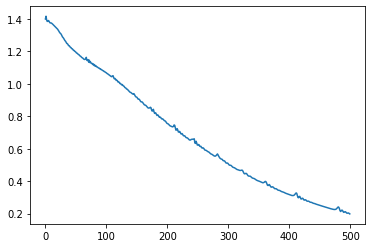

In [116]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [117]:
from sklearn.metrics import classification_report
confusion = torch.zeros(output_neurons, output_neurons)
Y_pred = net(X)
_, predicted = torch.max(F.softmax(Y_pred,1), 1)
for i in range(x_array.shape[0]):
    actual_class = Y.data[i]
    predicted_class = predicted.data[i]
    confusion[actual_class][predicted_class] += 1
print('')
print('Confusion matrix for training:')
print(confusion.numpy())


Confusion matrix for training:
[[30.  1.  4.  1.]
 [ 1. 36.  3.  0.]
 [ 2.  0. 30.  2.]
 [ 1.  0.  1. 37.]]


In [118]:
x_array_test = test_data[:, 1:86]
y_array_test = test_data[:, 0]
X_test = torch.tensor(x_array_test, dtype=torch.float)
Y_test = torch.tensor(y_array_test, dtype=torch.long)

In [119]:
print(len(Y_test))

43


In [120]:
Y_pred_test = net(X_test)
_, predicted_test = torch.max(F.softmax(Y_pred_test,1), 1)
total_test = predicted_test.size(0)
correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())
confusion = torch.zeros(output_neurons, output_neurons)
for j in range(x_array_test.shape[0]):
    actual_class = Y_test.data[j]
    predicted_class = predicted_test.data[j]
    confusion[actual_class][predicted_class] += 1
print('Confusion matrix for training:')
print(confusion.numpy())    
print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))


Confusion matrix for training:
[[11.  0.  1.  0.]
 [ 0.  7.  0.  1.]
 [ 1.  0. 12.  1.]
 [ 0.  0.  0.  9.]]
Testing Accuracy: 90.70 %


In [121]:
TP0 = confusion.numpy()[0][0]
TP1 = confusion.numpy()[1][1]
TP2 = confusion.numpy()[2][2]
TP3 = confusion.numpy()[3][3]

In [122]:
FP0 = confusion.numpy()[1][0]+confusion.numpy()[2][0]+confusion.numpy()[3][0]
FP1 = confusion.numpy()[0][1]+confusion.numpy()[2][1]+confusion.numpy()[3][1]
FP2 = confusion.numpy()[0][2]+confusion.numpy()[1][2]+confusion.numpy()[3][2]
FP3 = confusion.numpy()[0][3]+confusion.numpy()[1][3]+confusion.numpy()[2][3]

In [123]:
FN0 = confusion.numpy()[0][1]+confusion.numpy()[0][2]+confusion.numpy()[0][3]
FN1 = confusion.numpy()[1][0]+confusion.numpy()[1][2]+confusion.numpy()[1][3]
FN2 = confusion.numpy()[2][0]+confusion.numpy()[2][1]+confusion.numpy()[2][3]
FN3 = confusion.numpy()[3][0]+confusion.numpy()[3][1]+confusion.numpy()[3][2]

In [124]:
prcision0 = TP0/(TP0+FP0)
prcision1 = TP1/(TP1+FP1)
prcision2 = TP2/(TP2+FP2)
prcision3 = TP3/(TP3+FP3)
recall0 = TP0/(TP0+FN0)
recall1 = TP1/(TP1+FN1)
recall2 = TP2/(TP2+FN2)
recall3 = TP3/(TP3+FN3)
f1scor0 = 2*prcision0*recall0/(prcision0+recall0)
f1scor1 = 2*prcision1*recall1/(prcision1+recall1)
f1scor2 = 2*prcision2*recall2/(prcision2+recall2)
f1scor3 = 2*prcision3*recall3/(prcision3+recall3)

print(prcision0,recall0,f1scor0,prcision1,recall1,f1scor1,prcision2,recall2,f1scor2,prcision3,recall3,f1scor3)

0.9166667 0.9166667 0.9166666865348816 1.0 0.875 0.9333333333333333 0.9230769 0.85714287 0.8888888955933893 0.8181818 1.0 0.9000000262260447
